In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, StringIndexer
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

In [2]:
spark = SparkSession.builder \
    .appName("cource_work_fraud_detection") \
    .master("spark://localhost:7077") \
    .config('deploy-mode', 'cluster') \
    .config('spark.executor.memory', '20g') \
    .getOrCreate()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/02 07:34:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file_path = "file:///opt/spark/data/creditcard.csv"
fraud_df = spark.read.csv(file_path, header=True, inferSchema=True)

fraud_df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

# Огляд набору даних: Виявлення шахрайства

Цей набір даних містить інформацію про транзакції, яка використовується для виявлення шахрайської активності. Дані складаються з різноманітних характеристик, що описують кожну транзакцію, а також цільової мітки, яка вказує, чи була транзакція шахрайською.

---

## **Опис стовпців**

### **1. Time (Час)**  
- **Опис**: Відображає кількість секунд, які пройшли з моменту першої транзакції у наборі даних.  

### **2. V1 до V28**  
- **Опис**: Анонімізовані числові ознаки, отримані за допомогою аналізу головних компонент (PCA).  

### **3. Amount (Сума)**  
- **Опис**: Відображає грошову суму транзакції.  

### **4. Class (Клас)**  
- **Опис**: Цільова мітка для класифікації:  
  - `0`: Нешахрайська транзакція.  
  - `1`: Шахрайська транзакція.  

---

## **Характеристики набору даних**  
- **Загальна кількість ознак**: 31 (1 час, 28 компонент PCA, 1 сума, 1 мітка класу).  
- **Дисбаланс даних**:  
  - Шахрайські транзакції значно поступаються за кількістю нешахрайським.  
  - Необхідно застосовувати методи балансування для уникнення зміщення моделі.  
- **Анонімізовані ознаки**:  
  - Набір даних зберігає конфіденційність і не містить оригінальних даних про транзакції.  




[Row(Time=169142.0, V1=-1.92788332105459, V2=1.12565266367046, V3=-4.51833064132991, V4=1.74929253346589, V5=-1.56648729197754, V6=-2.01049423115212, V7=-0.882849830858081, V8=0.697211109261327, V9=-2.0649452874475, V10=-5.58779378195338, V11=2.1157951772133, V12=-5.4174240819973, V13=-1.23512263142388, V14=-6.66517689463338, V15=0.401700686738171, V16=-2.89782511671737, V17=-4.57052943365069, V18=-1.31514721385427, V19=0.391167040935071, V20=1.25296673470361, V21=0.778583978950071, V22=-0.319188818860513, V23=0.639418961153121, V24=-0.294885040380029, V25=0.537502535542985, V26=0.788395056528708, V27=0.292679966295281, V28=0.147967928722538, Amount=390.0, Class=1, Hour=22, TimePeriod='Evening'), Row(Time=169347.0, V1=1.37855899734127, V2=1.28938093711056, V3=-5.00424678441137, V4=1.4118498419441, V5=0.442580635567782, V6=-1.3265359338336, V7=-1.41316995590712, V8=0.248525467627175, V9=-1.12739593417081, V10=-3.23215317539514, V11=2.8584658156696, V12=-3.09691489835154, V13=-0.79253243

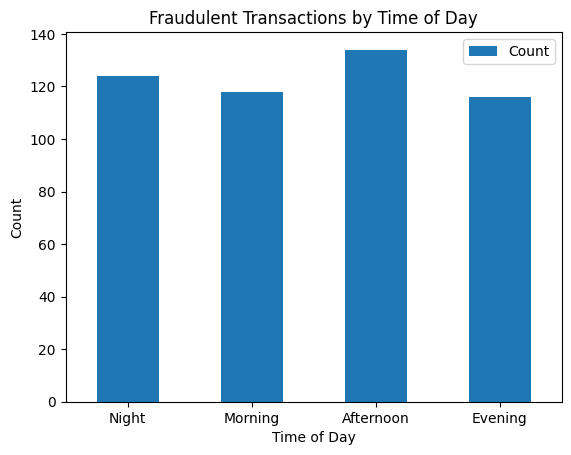

Night:  124
Morning:  118
Afternoon:  134
Evening:  116


In [18]:
from pyspark.sql.functions import when, col, expr
import matplotlib.pyplot as plt
import pandas as pd

# Add a column for hour of the day
fraud_df = df.where(col("Class") == 1)
fraud_df = fraud_df.withColumn("Hour", (col("Time") % 86400 / 3600).cast("integer"))

print(fraud_df.tail(5))

# Define time periods
fraud_df = fraud_df.withColumn(
    "TimePeriod",
    when((col("Hour") >= 0) & (col("Hour") < 6), "Night")
    .when((col("Hour") >= 6) & (col("Hour") < 12), "Morning")
    .when((col("Hour") >= 12) & (col("Hour") < 18), "Afternoon")
    .otherwise("Evening")
)

# Show the updated DataFrame
night = fraud_df.filter(col("TimePeriod") == "Night").count()
morning = fraud_df.filter(col("TimePeriod") == "Morning").count()
afternoon = fraud_df.filter(col("TimePeriod") == "Afternoon").count()
evening = fraud_df.filter(col("TimePeriod") == "Evening").count()

summary_df = pd.DataFrame(
    data=[night, morning, afternoon, evening],
    index=["Night", "Morning", "Afternoon", "Evening"],
    columns=["Count"],
)

summary_df.plot(kind="bar", title="Fraudulent Transactions by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

print("Night: ", night)
print("Morning: ", morning)
print("Afternoon: ", afternoon)
print("Evening: ", evening)


Перейдемо до використання класифікації для виявлення шахрайства в транзакціях. Використаємо oversampling для балансування даних та використаємо різні моделі класифікації для порівняння їх ефективності.

In [4]:
fraud_count = fraud_df.where(col("Class") == 1).count()
print(fraud_count)
non_fraud_df = fraud_df.where(col("Class") == 0)

non_fraud_count = non_fraud_df.count()

n_samples_to_add = non_fraud_count - fraud_count
print(n_samples_to_add)
# Randomly sample the fraud transactions to add duplicates
fraud_oversampled_df = fraud_df.where(col("Class") == 1).sample(withReplacement=True, fraction=n_samples_to_add / fraud_count, seed=3445)

# Combine the oversampled fraud data with the non-fraud data
balanced_df = non_fraud_df.union(fraud_oversampled_df)

# Show the new counts for validation
balanced_fraud_count = balanced_df.filter(balanced_df['Class'] == 1).count()
balanced_non_fraud_count = balanced_df.filter(balanced_df['Class'] == 0).count()

print(f"Balanced Fraud transactions: {balanced_fraud_count}")
print(f"Balanced Non-fraud transactions: {balanced_non_fraud_count}")

492
283823


25/01/02 07:34:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Balanced Fraud transactions: 283211
Balanced Non-fraud transactions: 284315


In [6]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the feature columns (excluding 'Class' and 'time')
feature_columns = [col for col in balanced_df.columns if col not in ['Class', 'Time']]

# VectorAssembler to combine features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
lr = LogisticRegression(labelCol="Class", featuresCol="features")

# Create a pipeline that first indexes the categorical column and then performs classification
pipeline = Pipeline(stages=[assembler, lr])

# Split the data into training and test sets
train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=3445)

# Train the model
model = pipeline.fit(train_df)

# Make predictions on the test data
predictions = model.transform(test_df)

# Evaluate the model (you can use different metrics depending on your needs)
evaluator = BinaryClassificationEvaluator(labelCol="Class")
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy}")

# Show the confusion matrix
predictions.groupBy("Class", "prediction").count().show()



25/01/02 07:34:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Model accuracy: 0.9866308687319001


25/01/02 07:34:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+----------+-----+
|Class|prediction|count|
+-----+----------+-----+
|    0|       0.0|55294|
|    0|       1.0| 1268|
|    1|       0.0| 4637|
|    1|       1.0|51926|
+-----+----------+-----+



In [27]:
# Use the random forest classifier

from pyspark.ml.classification import RandomForestClassifier

# Define the random forest classifier
rf = RandomForestClassifier(labelCol="Class", featuresCol="features")

# Create a new pipeline that includes the random forest classifier
pipeline_rf = Pipeline(stages=[assembler, rf])

# Train the model
model_rf = pipeline_rf.fit(train_df)

# Make predictions on the test data
predictions_rf = model_rf.transform(test_df)

# Evaluate the model
accuracy_rf = evaluator.evaluate(predictions_rf)
print(f"Random forest accuracy: {accuracy_rf}")

# Show the confusion matrix
predictions_rf.groupBy("Class", "prediction").count().show()

Random forest accuracy: 0.9891977391060208
+-----+----------+-----+
|Class|prediction|count|
+-----+----------+-----+
|    0|       0.0|56362|
|    0|       1.0|  200|
|    1|       0.0| 5486|
|    1|       1.0|51077|
+-----+----------+-----+



Виконаємо підбір гіперпараметрів для кращої моделі та оцінимо її ефективність за допомогою метрик оцінки класифікації.

In [33]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Define the Random Forest classifier
rf = RandomForestClassifier(labelCol="Class", featuresCol="features")

# Define the parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 50, 100])  # Number of trees
             .addGrid(rf.maxDepth, [5, 10, 15, 20])  # Max depth of the tree
             .addGrid(rf.maxBins, [16, 32, 64, 128])  # Max bins used for splitting data
             .build())

# Set up the CrossValidator
evaluator = BinaryClassificationEvaluator(labelCol="Class")
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Using 3-fold cross-validation

# Create the pipeline (with necessary feature transformation)
indexer = StringIndexer(inputCol="TimePeriod", outputCol="TimePeriod_index")
assembler = VectorAssembler(inputCols=feature_columns + ['TimePeriod_index'], outputCol="features")
pipeline = Pipeline(stages=[indexer, assembler, crossval])

# Split the data into training and test sets
train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=3445)

# Train the model using cross-validation
model = pipeline.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

# Evaluate the model's performance
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy}")

24/12/29 14:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1091.1 KiB
24/12/29 14:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1147.6 KiB
24/12/29 14:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1397.7 KiB
24/12/29 14:27:50 WARN DAGScheduler: Broadcasting large task binary with size 1079.0 KiB
24/12/29 14:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1238.6 KiB
24/12/29 14:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1541.3 KiB
24/12/29 14:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1853.1 KiB
24/12/29 14:27:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/12/29 14:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/12/29 14:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/29 14:28:00 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/29 14:28:01 WARN DAGSchedul

Model accuracy: 0.9999864186392038


In [38]:
# Show the confusion matrix
predictions.groupBy("Class", "prediction").count().show()

+-----+----------+-----+
|Class|prediction|count|
+-----+----------+-----+
|    0|       0.0|56492|
|    0|       1.0|    4|
|    1|       1.0|56932|
+-----+----------+-----+

Best model


AttributeError: 'PipelineModel' object has no attribute 'bestModel'

24/12/29 15:30:52 ERROR TaskSchedulerImpl: Lost executor 0 on 172.21.0.8: worker lost: 172.21.0.8:46345 got disassociated
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2690_6 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2616_20 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2690_3 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2616_16 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2616_7 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2690_10 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2616_11 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2690_23 !
24/12/29 15:30:52 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2616_1 !
24/12/29 15:30:52 